# Watershed "instance segmentation" from semantic segmentation

## Imports and fns

In [28]:
import glob
import matplotlib.pyplot as pl
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from patchify import patchify
import napari


def patch_train_label(raster, labels, img_size, channels=False, merge_channel=False):
    samp_rast = tiff.imread(raster[0])
    img_base_size = samp_rast.shape[0]
    n = len(raster)
    m = (img_base_size // img_size) ** 2

    if not channels:
        channels = samp_rast.shape[-1]

    if merge_channel:
        channels += tiff.imread(merge_channel[0]).shape[-1]

    data_train = np.zeros((n * m, img_size, img_size, channels))
    data_label = np.zeros((n * m, img_size, img_size))

    for k in range(n):
        if merge_channel:
            r = np.concatenate(
                (tiff.imread(raster[k]), tiff.imread(merge_channel[k])), axis=-1
            )
        else:
            r = tiff.imread(raster[k])[..., :channels]

        # Only read in the specified number of channels from input raster
        patches_train = patchify(
            r,
            (img_size, img_size, channels),
            step=img_size,
        )
        patches_label = patchify(
            tiff.imread(labels[k]), (img_size, img_size), step=img_size
        )
        data_train[k * m : (k + 1) * m, :, :, :] = patches_train.reshape(
            -1, img_size, img_size, channels
        )
        data_label[k * m : (k + 1) * m, :, :] = patches_label.reshape(
            -1, img_size, img_size
        )

    data_label = (data_label > 0).astype("int")
    data_label = np.expand_dims(data_label, axis=-1)
    data_train = data_train.astype("float") / 255

    return data_train, data_label

## Data preparation

In [16]:
# Patchify hand-labeled data PLUS NIR data
data_dir = "../../data/"
hand_rgb_dir = f"{data_dir}train_rgb/"
hand_nir_dir = f"{data_dir}train_nir/"
hand_label_dir = f"{data_dir}label/"

patch_rgb = glob.glob(f"{hand_rgb_dir}*.tif")
patch_nir = glob.glob(f"{hand_nir_dir}*.tif")
patch_label = glob.glob(f"{hand_label_dir}*.tif")
patch_rgb.sort()
patch_label.sort()

data_train, data_label = patch_train_label(
    patch_rgb, patch_label, 128, merge_channel=patch_nir
)

x_train, x_test, y_train, y_test = train_test_split(
    data_train, data_label, test_size=0.2, random_state=157
)

print(
    f"\nSizes with only hand-labeled data:\n\
x_train: {x_train.shape}\n\
y_train: {y_train.shape}\n\
x_test: {x_test.shape}\n\
y_test: {y_test.shape}"
)

# Patchify watershed data (pre-patchified)
data_dir = "../../data/watershed/512/"
patched_watershed_rgbi_dir = f"{data_dir}rgbi/"
patched_watershed_label_dir = f"{data_dir}labels/"

watershed_rgbi = glob.glob(f"{patched_watershed_rgbi_dir}*.tif")
watershed_labels = glob.glob(f"{patched_watershed_label_dir}*.tif")
watershed_rgbi.sort()
watershed_labels.sort()

data_train, data_label = patch_train_label(watershed_rgbi, watershed_labels, 128)

x_train = np.concatenate((x_train, data_train), axis=0)
y_train = np.concatenate((y_train, data_label), axis=0)

print(
    f"\nSizes after adding watershed data:\n\
x_train: {x_train.shape}\n\
y_train: {y_train.shape}\n\
x_test: {x_test.shape}\n\
y_test: {y_test.shape}"
)


Sizes with only hand-labeled data:
x_train: (460, 128, 128, 4)
y_train: (460, 128, 128, 1)
x_test: (116, 128, 128, 4)
y_test: (116, 128, 128, 1)

Sizes after adding watershed data:
x_train: (5644, 128, 128, 4)
y_train: (5644, 128, 128, 1)
x_test: (116, 128, 128, 4)
y_test: (116, 128, 128, 1)


1/1 [==============================] - 1s 571ms/step


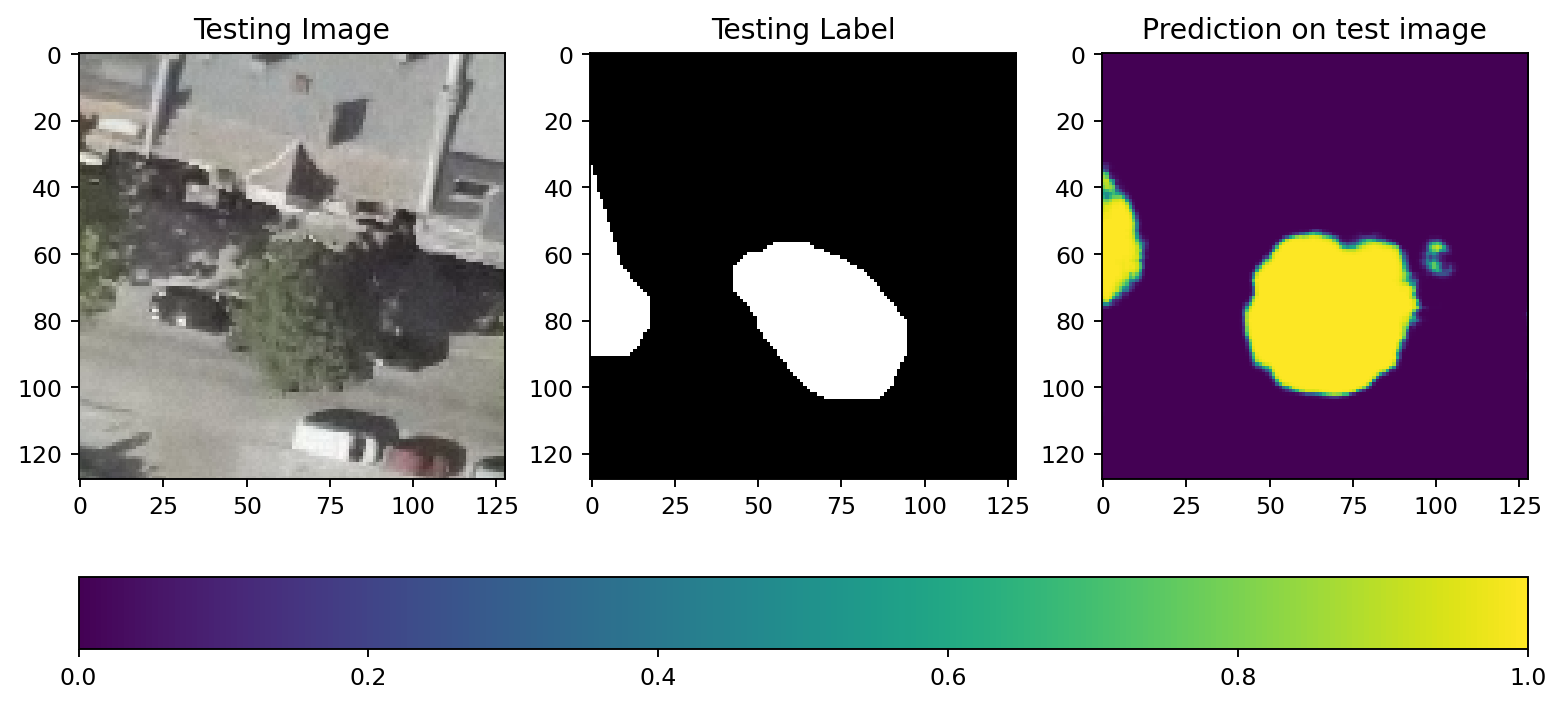

In [68]:
model = load_model("../../labs/lab4/model_rgb.hdf5", compile=False)

# y_pred = model.predict(x_test)

# # Convert sigmoid probability to classification
# y_pred_thresholded = y_pred > 0.5

# IOU_keras = MeanIoU(num_classes=2)
# IOU_keras.update_state(y_pred_thresholded, y_test)
# print("Mean IoU =", IOU_keras.result().numpy())

# %%
# Look through some random predictions and compare with the test images
# for quality
threshold = 0.2
k = np.random.randint(0, len(x_test) - 1)

test_img = x_test[k]
ground_truth = y_test[k]
prediction = model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

fg, ax = pl.subplots(1, 3, figsize=(11, 5), dpi=170)
ax[0].set_title("Testing Image")
ax[0].imshow(test_img[:, :, :3])
# ax[0].imshow(prediction > 0.5, cmap="gray", alpha=0.4)
ax[1].set_title("Testing Label")
ax[1].imshow(ground_truth[:, :, 0], cmap="gray")
ax[2].set_title("Prediction on test image")
im = ax[2].imshow(prediction)
fg.colorbar(im, ax=ax, location="bottom")

In [19]:
prediction.shape

(128, 128)

In [58]:
regions[0].bbox

(58, 0, 75, 5)

1/1 [==============================] - 0s 297ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 211ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 216ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 200ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 206ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 198ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 201ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 217ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 225ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


1/1 [==============================] - 0s 213ms/step


/var/folders/tg/xkrccwk90gd5c533b2lwm7l00000gn/T/ipykernel_21640/1444709195.py:33: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)


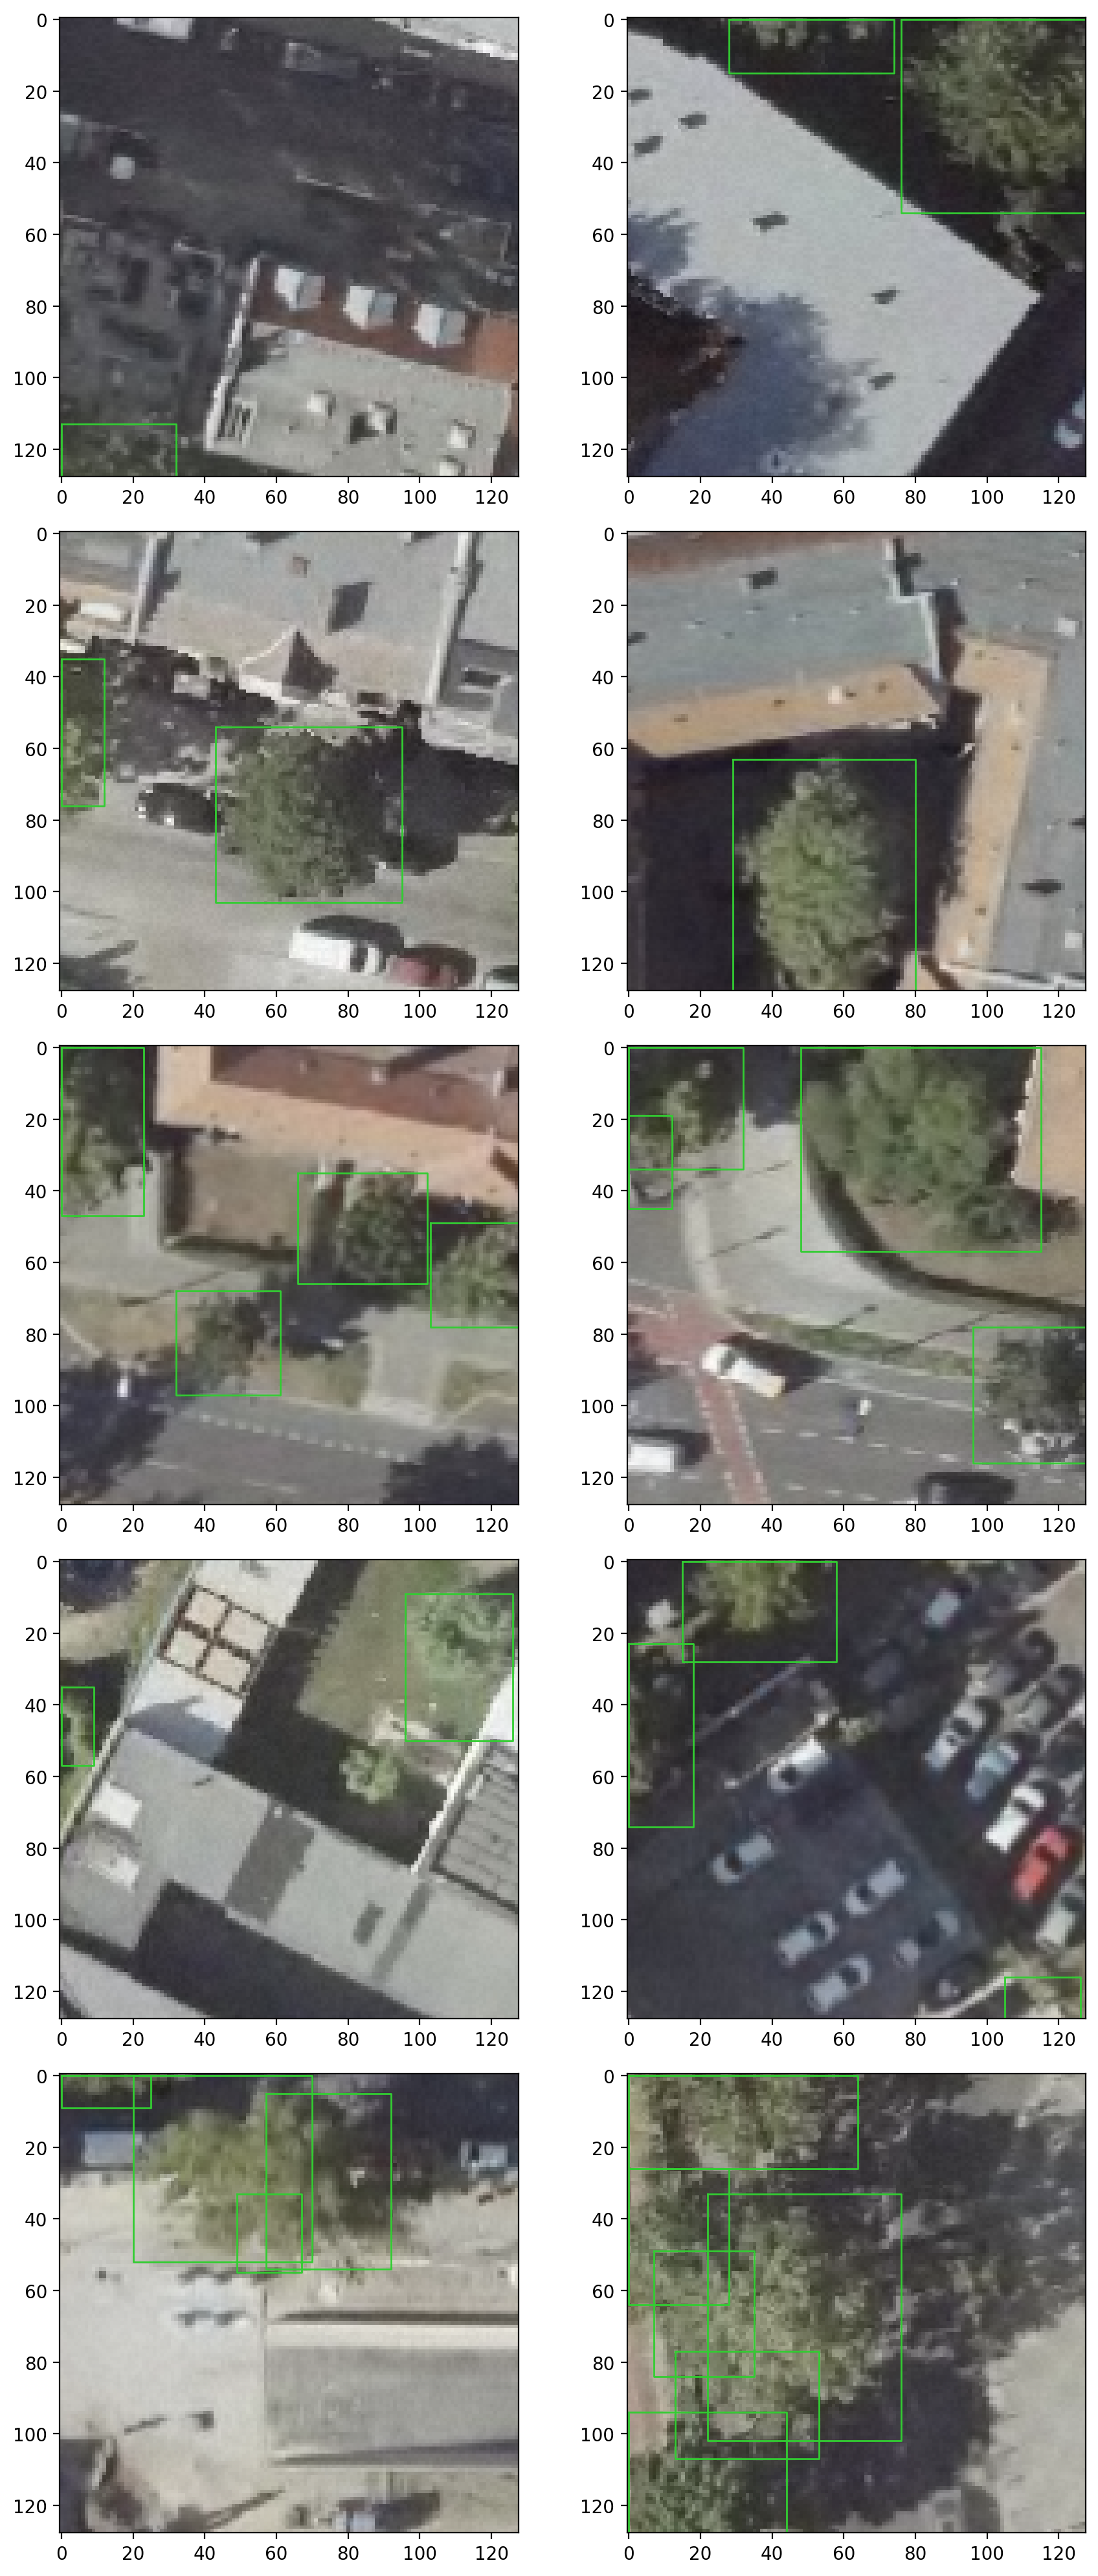

In [63]:
nsx = [2, 4, 5, 10]
thx = [4, 5, 8]

neighborhood_size = 5
threshold = 4

from matplotlib.pyplot import tight_layout
import scipy.ndimage as ndimage
from skimage.segmentation import watershed
from skimage.measure import regionprops
from skimage.color import label2rgb

viewer = napari.Viewer()

areas = [10, 20, 30, 40, 50]
ratios = [0.0001, 0.001, 0.01, 0.1, 0.5]

area = 40
ratio = 0.1

_, ax = pl.subplots(5, 2, figsize=(10, 20), dpi=200, tight_layout=True)
ax = ax.ravel()

import random


for i, k in enumerate(random.sample(range(0, len(x_test)), 10)):
    test_img = x_test[k]
    ground_truth = y_test[k]
    prediction = model.predict(np.expand_dims(test_img, 0))[0, :, :, 0]

    p_smooth = ndimage.gaussian_filter(prediction, threshold)
    p_max = ndimage.filters.maximum_filter(p_smooth, neighborhood_size)
    local_maxima = p_smooth == p_max
    local_maxima[prediction == 0] = 0
    labeled, num_objects = ndimage.label(local_maxima)
    xy = np.array(
        ndimage.center_of_mass(input=prediction, labels=labeled, index=range(1, num_objects + 1))
    )
    min_height = 0.3
    binary_mask = np.where(prediction >= min_height, 1, 0)
    binary_mask = ndimage.binary_fill_holes(binary_mask).astype(int)

    labels = watershed(-prediction, labeled, mask=binary_mask)

    regions = regionprops(labels)
    filtered_regions = np.zeros((prediction.shape[0], prediction.shape[1]), dtype=int)

    for region in regions:
        if region.area >= area and (
            region.axis_minor_length / region.axis_major_length >= ratio
        ):
            filtered_regions[region.coords[:, 0], region.coords[:, 1]] = region.label
            minr, minc, maxr, maxc = region.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax[i].plot(bx, by, c="limegreen", lw=1)

    ax[i].imshow(test_img[..., :3])
    viewer.add_image(ground_truth, blending="opaque", name=f"img_{i}")
    # viewer.add_labels(filtered_regions, name=f"img_{i}")